### Задание
Давайте попробуем провести SPRT-анализ на реальном А/Б-тесте.

Вы работаете аналитиком в команде искателей. Команда внедрила новую карточку объявлений авто. Основная цель – вырастить конверсию в контакт в рамках одной сессии.

А/Б-тест провели, теперь нужно проанализировать результаты. У нас есть следующие данные: 
- `cont_conv_A` - конверсия по i-му пользователю в А группе 
- `cont_conv_B` - конверсия по j-му пользователю в B группе. 

Данные в обеих колонках датасета отсортированы по мере поступления в тест, т.е. более ранние строки – это пользователи, попавшие в тест раньше.

Менеджерам нужно дать ответ, помогло ли изменение карточки авто повысить конверсию.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import statsmodels.stats.power as smp

In [2]:
df = pd.read_csv("SPRT_homework_1.csv")

In [3]:
df.head()

,cont_conv_A,cont_conv_B
0,0,0
1,0,0
2,1,0
3,1,0
4,0,0


### Задание 1
Проведите базовый z-тест на пропорцию. Тест двусторонний.

Введите значение p-value в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [4]:
group_a = df["cont_conv_A"]
group_b = df["cont_conv_B"]

In [5]:
_, pval = proportions_ztest(
    count=[group_a.sum(), group_b.sum()], nobs=[len(group_a), len(group_b)]
)

In [6]:
round(pval, 3)

0.024

### Задание 2 (1/2)
Проведите SPRT.

Параметры для проведения теста следующие:

- alpha = 0.05
- beta = 0.2
- относительный mde = 0.05 от средней cont_conv_A в группе А

Укажите, какая гипотеза верна по мнению SPRT?

### Задание 2 (2/2)
На каком размере выборки SPRT останавливается и делает вывод?

Введите значение в поле ниже в формате целого числа.

In [7]:
# создадим функцию проводящую тест на проверку гипотезы о равенстве долей с попощью SPRT
def get_decision_list_sprt_binom(
    values_A, values_B, alpha=0.05, beta=0.2, mde=0.1
):
    """Функция проводящая SPRT анализ для пропорций (долей, конверсий)
    values_A - массив значенений коверсии (0, 1) в группе А
    values_B - массив значенений коверсии (0, 1) в группе И
    alpha - уровень статзначимости, который выдерживает SPRT
    beta - уровень ошибки второго рода, который выдерживает SPRT
    mde - абсолютная разница между долями в двух группах, MDE проверяемый в SPRT

    return
    - early_stop_index: индекс на котором SPRT остановился и принял решение.
        Если по результатам всех наблюдений SPRT не смог принять решение возвращается len(data)
    - inference: какая гипотеза была принята по результатам SPRT
    - left_bound_list: массив границ для принятия решения. Длиной early_stop_index
    - right_bound_list: массив границ для принятия решения. Длиной early_stop_index
    - S_list: массив рассчитываемых значений отражающих изменение динамики разницы долей. Длиной early_stop_index
    - cum_diff_list: массив кумулятивной нарастающей разницы между долями в двух группах. Длиной early_stop_index
    """
    min_len = int(np.mean([len(values_A), len(values_B)]))
    A = math.log(beta / (1 - alpha))
    B = math.log((1 - beta) / alpha)
    p = (
        values_A.mean() + values_B.mean()
    ) / 2  # генеральная доля по двум выборкам

    left_bound_list = []
    right_bound_list = []
    S_list = []
    cum_diff_list = []

    for i in range(100, min_len):
        p0_i = np.mean(values_A[0:i])
        p1_i = np.mean(values_B[0:i])

        # p = (p0_i + p1_i)/2

        disp = p * (1 - p)
        diff = p1_i - p0_i
        left_bound = 2 * disp * A / mde
        right_bound = 2 * disp * B / mde

        S = (i + 1) * (diff - mde / 2)

        left_bound_list.append(left_bound)
        right_bound_list.append(right_bound)
        S_list.append(S)
        cum_diff_list.append(diff)

        if S < left_bound:
            return {
                "early_stop_index": i,
                "inference": "Accept H0",
                "left_bound_list": left_bound_list,
                "right_bound_list": right_bound_list,
                "S_list": S_list,
                "cum_diff_list": cum_diff_list,
            }
        if S > right_bound:
            return {
                "early_stop_index": i,
                "inference": "Accept H1",
                "left_bound_list": left_bound_list,
                "right_bound_list": right_bound_list,
                "S_list": S_list,
                "cum_diff_list": cum_diff_list,
            }
    return {
        "early_stop_index": i,
        "inference": "Continue",
        "left_bound_list": left_bound_list,
        "right_bound_list": right_bound_list,
        "S_list": S_list,
        "cum_diff_list": cum_diff_list,
    }

Средняя доля в группе А: 0.171. Средняя доля в группе B: 0.179
Наблюдаемая разница по всей группе: 0.00833
Вывод: Accept H1
На каком наблюдении сделан вывод: 15314
На каком наблюдении сделан вывод: 15314


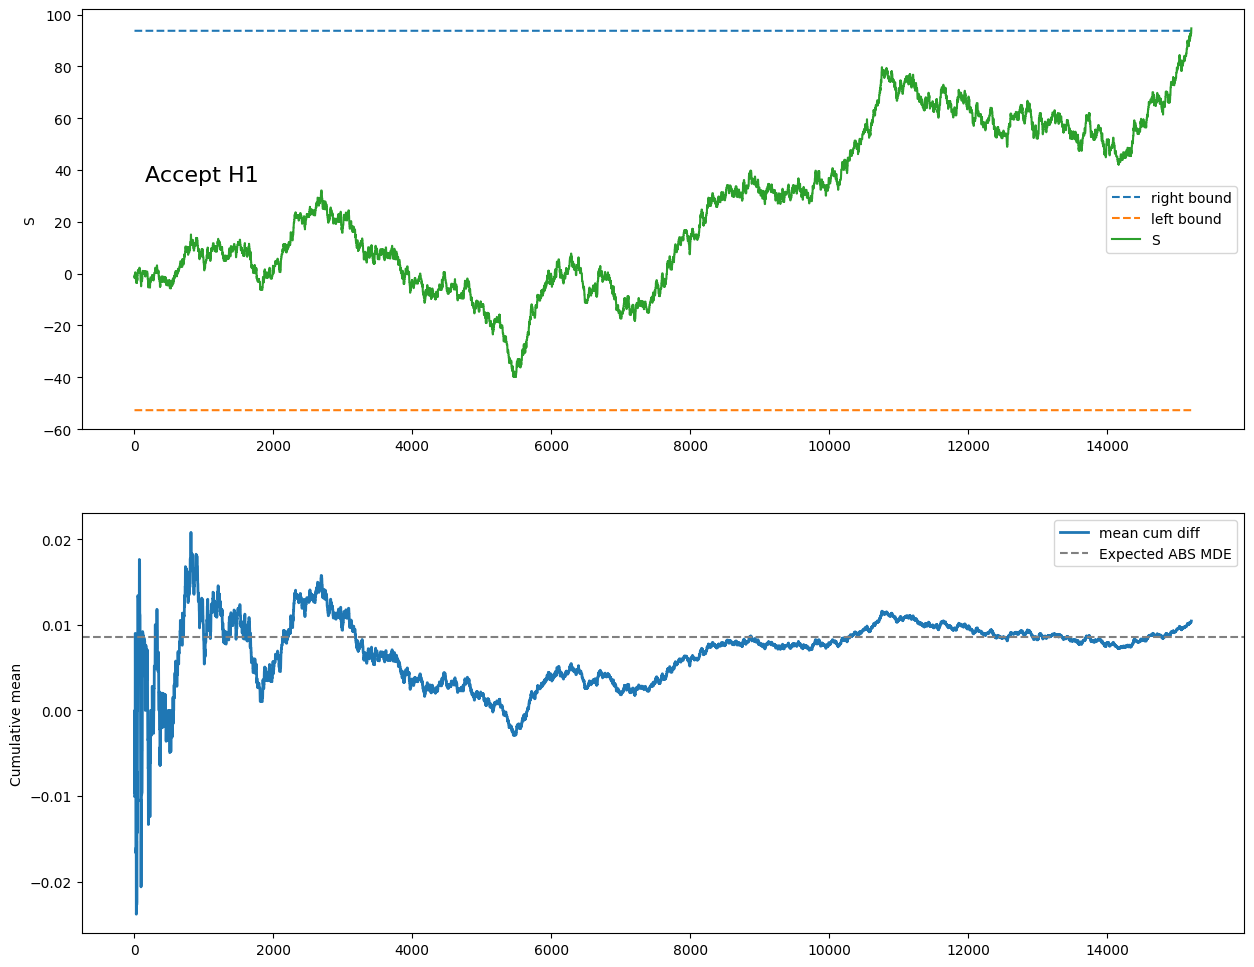

In [8]:
# определим размер выборки при Fixed Horizon для proportion тест
h0 = group_a.mean()
rel_mde = 0.05
h1 = h0 * (1 + rel_mde)
alpha = 0.05
beta = 0.2
mde_abs = h1 - h0

cohen_d = 2 * math.asin(np.sqrt(h0)) - 2 * math.asin(
    np.sqrt(h0 * (1 + rel_mde))
)
n_obs = smp.zt_ind_solve_power(
    effect_size=cohen_d, alpha=alpha, power=1 - beta, alternative="two-sided"
)
sample_size = round(n_obs)

print(
    "Средняя доля в группе А: {}. Средняя доля в группе B: {}".format(
        round(group_a.mean(), 3), round(group_b.mean(), 3)
    )
)
print(
    "Наблюдаемая разница по всей группе:",
    round(group_b.mean() - group_a.mean(), 5),
)

# проводим SPRT тест на полученных данных
inference_object = get_decision_list_sprt_binom(
    group_a, group_b, alpha=0.05, beta=0.2, mde=mde_abs
)
print("Вывод:", inference_object["inference"])
print(
    "На каком наблюдении сделан вывод:", inference_object["early_stop_index"]
)

# plot SPRT decprint('Вывод:', inference_object['inference'])
print(
    "На каком наблюдении сделан вывод:", inference_object["early_stop_index"]
)
fig, axes = plt.subplots(2, figsize=(15, 12))

sns.lineplot(
    ax=axes[0],
    x=np.arange(1, len(inference_object["right_bound_list"]) + 1),
    y=inference_object["right_bound_list"],
    ls="--",
    label="right bound",
)
sns.lineplot(
    ax=axes[0],
    x=np.arange(1, len(inference_object["left_bound_list"]) + 1),
    y=inference_object["left_bound_list"],
    ls="--",
    label="left bound",
)
sns.lineplot(
    ax=axes[0],
    x=np.arange(1, len(inference_object["S_list"]) + 1),
    y=inference_object["S_list"],
    label="S",
)
axes[0].set_ylabel(ylabel="S")
axes[0].text(
    y=np.quantile(inference_object["S_list"], 0.65),
    x=len(inference_object["S_list"]) * 0.01,
    s=inference_object["inference"],
    fontsize=16,
)
axes[0].legend()

sns.lineplot(
    ax=axes[1],
    x=np.arange(1, len(inference_object["right_bound_list"]) + 1),
    y=inference_object["cum_diff_list"],
    label="mean cum diff",
    linewidth=2,
)
axes[1].axhline(mde_abs, ls="--", color="gray", label="Expected ABS MDE")
axes[1].set_ylabel(ylabel="Cumulative mean")
axes[1].legend()

### Задание 3 (1/4)
Найдите среднее время остановки (размер выборки) SPRT для текущих данных и сравните с Fixed Horizon.

В этом степе определим размер выборки, необходимый для Fixed Horizon.

Параметры дизайна

- относительный MDE = 0.05
- альфа = 0.05
- бета = 0.2
- гипотеза - двусторонняя
- пропорция в выборке 50/50
- исторические данные - данные по конверсии в группе А

Введите значение в поле ниже в формате целого числа.

In [9]:
print("Размер выборки для Fixed Horizon:", sample_size)
print("mde_absolute:", round(mde_abs, 4))

Размер выборки для Fixed Horizon: 31121
mde_absolute: 0.0085


### Задание 3 (2/4)
В этом степе определим среднее время остановки для АА симуляций

Параметры симуляции

- перед запуском указать `np.random.seed(2)`
- кол-во симуляций = 300
- для симуляции будем брать исторические данные многократно выборки кодом `np.random.choice(data['cont_conv_A'], size=len(data['cont_conv_A']))`. 
- `replace` по умолчанию = `True`
- размер выборок в симуляции = sample size с предыдущего шага
- для получения требуемого ответа в цикле нужно делать обе симуляции одновременно (АА и АВ)

Введите значение в поле ниже в формате целого числа.

In [10]:
inference_AA_list = []
inference_AB_list = []
stop_index_list_AA = []
stop_index_list_AB = []
diffs_list_AA = []
diffs_list_AB = []
sim_num = 300
np.random.seed(2)

for i in tqdm(range(sim_num)):
    # сгенерируем данные с конверсией с h0 и h1 конверсиями (с размером выборок с запасом)
    a_group = np.random.choice(group_a, size=31121, replace=True)
    a1_group = np.random.choice(group_a, size=31121, replace=True)
    b_group = np.random.choice(group_b, size=31121, replace=True)

    inference_object_AA = get_decision_list_sprt_binom(
        a_group, a1_group, alpha=0.05, beta=0.2, mde=mde_abs
    )
    inference_object_AB = get_decision_list_sprt_binom(
        a_group, b_group, alpha=0.05, beta=0.2, mde=mde_abs
    )

    inference_AA = inference_object_AA["inference"]
    inference_AB = inference_object_AB["inference"]
    stop_index_AA = inference_object_AA["early_stop_index"]
    stop_index_AB = inference_object_AB["early_stop_index"]

    inference_AA_list.append(inference_AA)
    inference_AB_list.append(inference_AB)
    stop_index_list_AA.append(stop_index_AA)
    stop_index_list_AB.append(stop_index_AB)

FP = (np.array(inference_AA_list) == "Accept H1").sum() / sim_num
FP_CI = proportion_confint(
    (np.array(inference_AA_list) == "Accept H1").sum(), sim_num, alpha=0.05
)
power = (np.array(inference_AB_list) == "Accept H1").sum() / sim_num
power_CI = proportion_confint(
    (np.array(inference_AB_list) == "Accept H1").sum(), sim_num, alpha=0.05
)

  0%|          | 0/300 [00:00<?, ?it/s]

### Задание 3 (3/4)
В этом степе определим среднее время остановки для АБ симуляций.

Параметры симуляции те же, что и в предыдущем степе.

Введите значение в поле ниже в формате целого числа.

### Задание 3 (4/4)
Оцените мощность SPRT методики на наших данных группы А и Б и относительном MDE = 0.05.

Параметры симуляции те же.

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

### Задание 3 (4/4)
Оцените мощность SPRT методики на наших данных группы А и Б и относительном MDE = 0.05.

Параметры симуляции те же.

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

FP rate = 0.04
Power rate = 0.7366666666666667
Stop index AA: 10696
Stop index AB: 14547
3.2. Среднее время остановки SPRT теста для АА-варианта = 10696


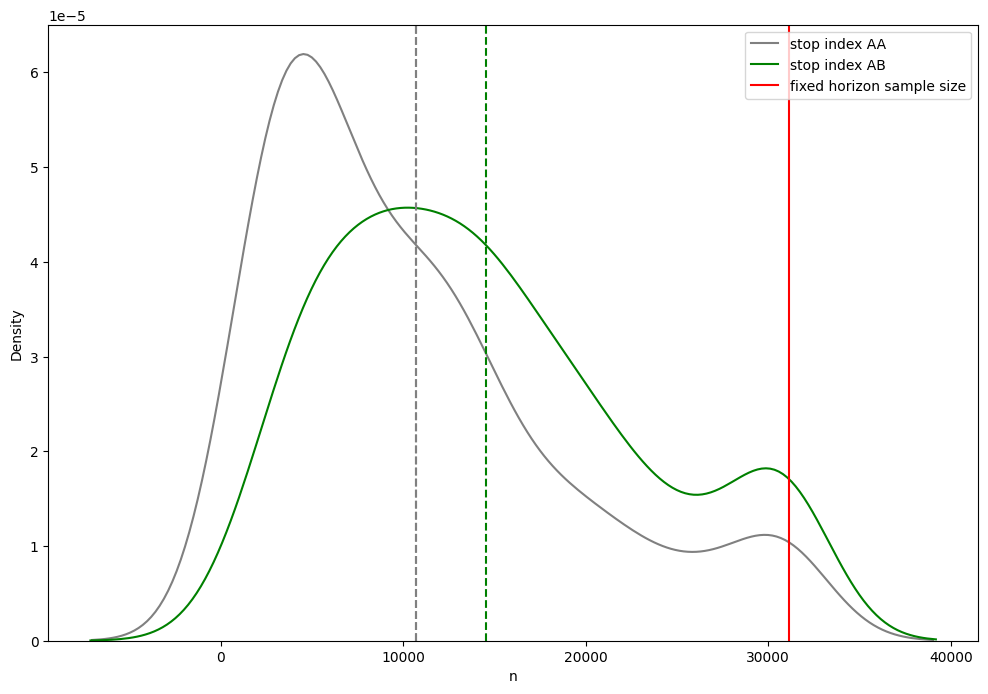

In [11]:
print("FP rate =", FP)
print("Power rate =", power)
print("Stop index AA:", round(np.mean(stop_index_list_AA)))
print("Stop index AB:", round(np.mean(stop_index_list_AB)))

# распределение времени остановки теста на конверсии с относительным MDE 5%
plt.figure(figsize=(12, 8))
sns.kdeplot(stop_index_list_AA, label="stop index AA", color="grey")
sns.kdeplot(stop_index_list_AB, label="stop index AB", color="green")
plt.axvline(x=np.mean(stop_index_list_AA), ls="--", color="grey")
plt.xlabel("n")
plt.axvline(x=np.mean(stop_index_list_AB), ls="--", color="green")
plt.axvline(x=sample_size, label="fixed horizon sample size", color="red")
plt.axvline(x=np.mean(stop_index_list_AA), ls="--", color="grey")
plt.legend()

print(
    "3.2. Среднее время остановки SPRT теста для АА-варианта =",
    round(np.mean(stop_index_list_AA)),
)